In [ ]:
from datetime import datetime
print(f"Execution Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


In [ ]:
# Package upgrade skipped - using environment default
print('Using default sagemaker_studio package from environment')


In [ ]:
from sagemaker_studio import Project
proj = Project()
s3_shared_conn = proj.connection('default.s3_shared')
s3_bucket = s3_shared_conn.data.s3_uri.rstrip('/').split('/')[-2]
print(f"Using S3 bucket: {s3_bucket}")

# Test 05: Customer Churn Analysis using Spark Connect

This notebook performs customers churn analytics using spark connect

## 🎯 Objective

Demonstrate how Spark Connect can be used for end-to-end analytics:

* Building a pipeline that ingests and transforms customer data
* Performing feature engineering and aggregations
* Running analytical queries
* Visualizing results locally with matplotlib

In [0]:
print(f"Performing customer churn analysis using Spark version: {spark.version}")

Performing customer churn analysis using Spark version: 3.5.6-amzn-1-SNAPSHOT


In [0]:
import randomfrom pyspark.sql import Rowdef generate_customer(i):    age = random.randint(18, 75)    gender = random.choice(["Male", "Female"])    plan_type = random.choice(["Basic", "Standard", "Premium"])    tenure = random.randint(1, 72)    monthly_charges = round(random.uniform(20, 120), 2)    total_charges = round(monthly_charges * tenure, 2)    complaints = random.randint(0, 5)    churn = 1 if (tenure < 12 and monthly_charges > 80) or (complaints > 2) else 0    return Row(        customer_id=i,        age=age,        gender=gender,        plan_type=plan_type,        tenure=tenure,        monthly_charges=monthly_charges,        total_charges=total_charges,        complaints=complaints,        churn=churn    )data = [generate_customer(i) for i in range(5000)]df = spark.createDataFrame(data)df.show(5)

+-----------+---+------+---------+------+---------------+-------------+----------+-----+
|customer_id|age|gender|plan_type|tenure|monthly_charges|total_charges|complaints|churn|
+-----------+---+------+---------+------+---------------+-------------+----------+-----+
|          0| 59|  Male|    Basic|    53|          65.61|      3477.33|         1|    0|
|          1| 42|  Male|    Basic|    15|          67.28|       1009.2|         4|    1|
|          2| 53|Female|    Basic|    44|           35.9|       1579.6|         0|    0|
|          3| 26|Female|    Basic|    10|          37.23|        372.3|         0|    0|
|          4| 56|Female|  Premium|    37|          97.29|      3599.73|         2|    0|
+-----------+---+------+---------+------+---------------+-------------+----------+-----+
only showing top 5 rows



In [0]:
df

DataFrame[customer_id: bigint, age: bigint, gender: string, plan_type: string, tenure: bigint, monthly_charges: double, total_charges: double, complaints: bigint, churn: bigint]

In [0]:
df.printSchema()df.describe().show()

root
 |-- customer_id: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- plan_type: string (nullable = true)
 |-- tenure: long (nullable = true)
 |-- monthly_charges: double (nullable = true)
 |-- total_charges: double (nullable = true)
 |-- complaints: long (nullable = true)
 |-- churn: long (nullable = true)



+-------+------------------+------------------+------+---------+-----------------+------------------+------------------+-----------------+-------------------+
|summary|       customer_id|               age|gender|plan_type|           tenure|   monthly_charges|     total_charges|       complaints|              churn|
+-------+------------------+------------------+------+---------+-----------------+------------------+------------------+-----------------+-------------------+
|  count|              5000|              5000|  5000|     5000|             5000|              5000|              5000|             5000|               5000|
|   mean|            2499.5|            46.491|  NULL|     NULL|           35.891| 70.09335200000004|2528.8703900000005|            2.509|             0.5344|
| stddev|1443.5200033252052|16.620275741188614|  NULL|     NULL|20.92384000168428|29.484655678304776|1925.7712080346944|1.703437506886582|0.49886512534216754|
|    min|                 0|                18

2025-11-01 22:22:47,100 - matplotlib.font_manager - INFO - generated new fontManager


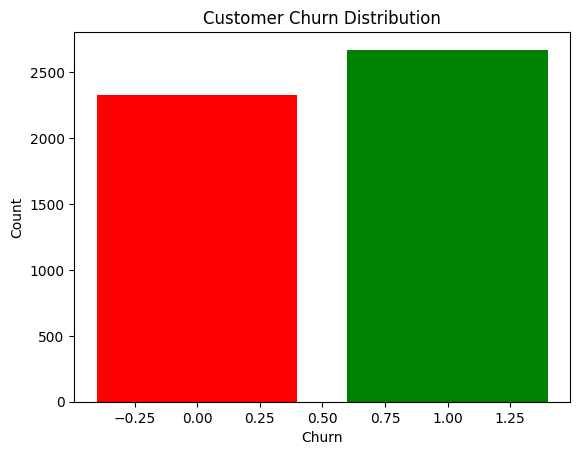

In [0]:
import matplotlib.pyplot as pltchurn_counts = df.groupBy("churn").count().toPandas()plt.bar(churn_counts["churn"], churn_counts["count"], color=["green", "red"])plt.title("Customer Churn Distribution")plt.xlabel("Churn")plt.ylabel("Count")plt.show()

In [0]:
from pyspark.sql.connect import functions as Fdf_transformed = (    df.withColumn("avg_monthly_spend", F.col("total_charges") / F.col("tenure"))      .withColumn("is_high_value", F.when(F.col("monthly_charges") > 70, 1).otherwise(0))      .withColumn("complaint_rate", F.col("complaints") / F.col("tenure")))df_transformed.show(5)

+-----------+---+------+---------+------+---------------+-------------+----------+-----+------------------+-------------+--------------------+
|customer_id|age|gender|plan_type|tenure|monthly_charges|total_charges|complaints|churn| avg_monthly_spend|is_high_value|      complaint_rate|
+-----------+---+------+---------+------+---------------+-------------+----------+-----+------------------+-------------+--------------------+
|          0| 59|  Male|    Basic|    53|          65.61|      3477.33|         1|    0|             65.61|            0|0.018867924528301886|
|          1| 42|  Male|    Basic|    15|          67.28|       1009.2|         4|    1|             67.28|            0| 0.26666666666666666|
|          2| 53|Female|    Basic|    44|           35.9|       1579.6|         0|    0|              35.9|            0|                 0.0|
|          3| 26|Female|    Basic|    10|          37.23|        372.3|         0|    0|37.230000000000004|            0|                 0.0|

In [0]:
churn_by_plan = (    df_transformed.groupBy("plan_type", "is_high_value")    .agg(F.mean("churn").alias("churn_rate"))    .orderBy("churn_rate", ascending=False))churn_by_plan.show()

+---------+-------------+------------------+
|plan_type|is_high_value|        churn_rate|
+---------+-------------+------------------+
| Standard|            1|0.5863746958637469|
|  Premium|            1|0.5793939393939394|
|  Premium|            0|0.5263157894736842|
| Standard|            0|0.5211912943871707|
|    Basic|            1|0.5208085612366231|
|    Basic|            0|0.4755813953488372|
+---------+-------------+------------------+



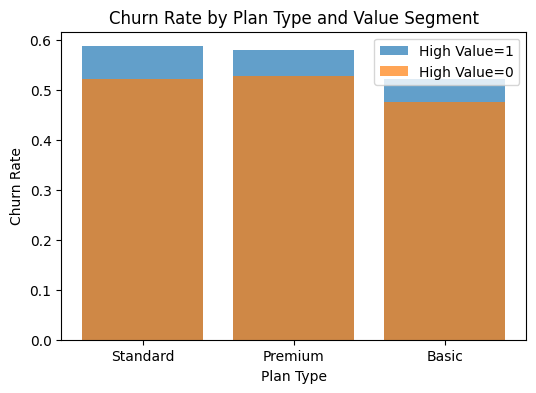

In [0]:
churn_plot = churn_by_plan.toPandas()plt.figure(figsize=(6,4))for val in churn_plot['is_high_value'].unique():    subset = churn_plot[churn_plot['is_high_value'] == val]    plt.bar(subset['plan_type'], subset['churn_rate'], alpha=0.7, label=f"High Value={val}")plt.title("Churn Rate by Plan Type and Value Segment")plt.xlabel("Plan Type")plt.ylabel("Churn Rate")plt.legend()plt.show()

In [0]:
high_churn_segments = (    df_transformed.filter(F.col("churn") == 1)    .groupBy("plan_type", "is_high_value")    .agg(F.count("*").alias("churned_customers"))    .orderBy("churned_customers", ascending=False))high_churn_segments.show(10)

+---------+-------------+-----------------+
|plan_type|is_high_value|churned_customers|
+---------+-------------+-----------------+
| Standard|            1|              482|
|  Premium|            1|              478|
| Standard|            0|              455|
|    Basic|            1|              438|
|  Premium|            0|              410|
|    Basic|            0|              409|
+---------+-------------+-----------------+



In [0]:
numeric_cols = ["age", "tenure", "monthly_charges", "total_charges", "complaints", "avg_monthly_spend"]corrs = [(c, float(df_transformed.stat.corr("churn", c))) for c in numeric_cols]spark.createDataFrame(corrs, ["feature", "correlation_with_churn"]).show()

+-----------------+----------------------+
|          feature|correlation_with_churn|
+-----------------+----------------------+
|              age|  -0.01816614537730...|
|           tenure|    -0.103635630772786|
|  monthly_charges|   0.05763260113157438|
|    total_charges|   -0.0787977944560232|
|       complaints|    0.8267155089443267|
|avg_monthly_spend|  0.057632601131574375|
+-----------------+----------------------+



### Key Insights
- Customers with shorter tenures and higher monthly charges tend to churn more.
- High-value customers on the Basic plan are at higher risk of churn.
- Complaints have a strong positive correlation with churn.
- Tenure and total charges have strong negative correlation with churn.